<a href="https://colab.research.google.com/github/blazyy/data-analysis-imdb/blob/master/imdb_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# Scraper

In [0]:
movie_names = []
movie_years = []
imdb_ratings = []
meta_ratings = []
movie_earnings = [] 
movie_genres = []
runtimes = []

pages = 10  # 10 pages per year.
start_year = 2000
end_year = 2018

for i in tqdm_notebook(range(start_year, end_year+1), total = end_year-start_year, unit = 'year'):
  k = 1
  for j in range(1, pages + 1):
    imdb_url = 'https://www.imdb.com/search/title?release_date=' + str(i) + '-01-01,' + str(i) + '-12-31&sort=num_votes,desc&start=' + str(k) + '&ref_=adv_nxt'
    page_unparsed = urllib.request.urlopen(imdb_url)
    page_parsed = BeautifulSoup(page_unparsed, 'html.parser')

    k += 50

    movie_divs = page_parsed.find_all('div', class_ = 'lister-item mode-advanced')

    for movie in movie_divs:
      skip_movie = False 

      meta_rating_unparsed = movie.find('div', class_ = 'inline-block ratings-metascore')
      gross_unparsed = movie.find_all('span', attrs = {'name' : 'nv'})

      if meta_rating_unparsed is None or gross_unparsed is None:
        continue
        
      temp = movie.find_all('span', attrs = {'name' : 'nv'})
      if len(temp) is not 2:
        continue
      else:
        movie_earnings.append(float(temp[1].string.strip('$').strip('M')))

      meta_ratings.append(int(meta_rating_unparsed.text.replace(" ", "").split("\n")[1]))
      movie_genres.append(movie.find('span', attrs = {'class' : 'genre'}).text.strip().split(",")[0])
      imdb_ratings.append(float(movie.find('div', class_ = 'inline-block ratings-imdb-rating').text))
      movie_names.append(movie.find('h3', class_ = 'lister-item-header').find('a').text)


      year = movie.find('span', class_ = 'lister-item-year text-muted unbold').text.split(" ")
      if len(year) == 1:
        movie_years.append(year[0][1:5])
      else:
        movie_years.append(year[1][1:5])

        
      runtimes.append(int(movie.find('span', class_ = 'runtime').text.strip('min')))

In [0]:
# movies = pd.DataFrame(list(zip(movie_names, movie_years, movie_genres, imdb_ratings, meta_ratings, movie_earnings, runtimes)), columns =['name', 'year', 'genre', 'imdb', 'meta', 'gross', 'runtime']) 
movies = pd.read_csv("movies.csv")
movies.drop("Unnamed: 0", axis = 1, inplace = True)


In [0]:
# movies.to_csv("movies.csv")
# files.download('movies.csv') 

In [388]:
movies.describe()

,imdb,meta,gross,runtime
count,4879.000000,4879.000000,4879.000000,4879.000000
mean,6.517422,56.015782,37.882578,107.050420
std,0.972277,17.866606,68.171028,18.179448
min,1.500000,1.000000,0.000000,61.000000
25%,6.000000,43.000000,0.720000,95.000000
50%,6.600000,57.000000,11.430000,104.000000
75%,7.200000,69.000000,45.130000,116.000000
max,9.000000,100.000000,936.660000,366.000000


In [389]:
movies.head()

,name,year,genre,imdb,meta,gross,runtime
0,Gladiator,2000,Action,8.5,67,187.71,155
1,Memento,2000,Mystery,8.5,80,25.54,113
2,Snatch,2000,Comedy,8.3,55,30.33,102
3,Requiem for a Dream,2000,Drama,8.3,68,3.64,102
4,X-Men,2000,Action,7.4,64,157.30,104


# Rating

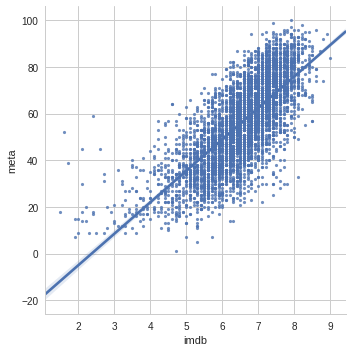

In [434]:
sns.lmplot(x = 'imdb', y = 'meta', data = movies, scatter_kws={"s": 10})

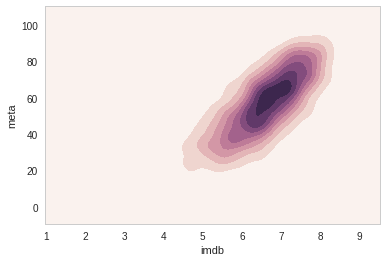

In [439]:
sns.kdeplot(movies['imdb'], movies['meta'], cmap = sns.cubehelix_palette(light = 1, as_cmap = True), shade = True)

There is a high positive correlation between both the scoring metrics.

**Inference 1: ** People and critics tend to have the same view on movies. Both have the same opinions one movies with a rating of 6 (or 60).

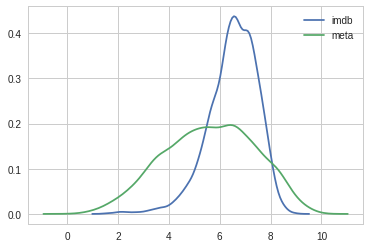

In [441]:
fig, ax = plt.subplots()
sns.kdeplot(movies['imdb'], ax = ax)
sns.kdeplot(movies['meta']/10, ax = ax)

**Inference 2 : ** Meta ratings follow a normal distribution while IMDb ratings tend to favour the 5 - 8 range.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


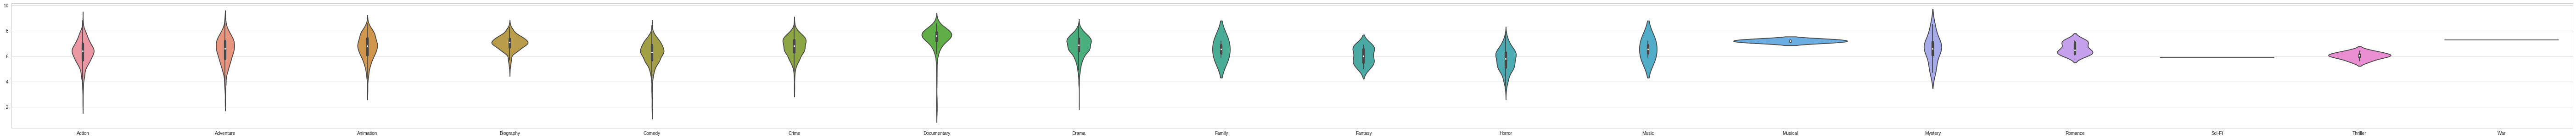

In [392]:
dicts = {}
for genre in movies['genre'].unique():
  dicts[genre] = movies[movies['genre'] == genre]['imdb']
               
temp = pd.DataFrame(dicts)

fig, ax = plt.subplots(figsize=(100,5))
sns.violinplot(temp)
plt.show()

**Inference 3: ** Biography movies tend to have the high ratings.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


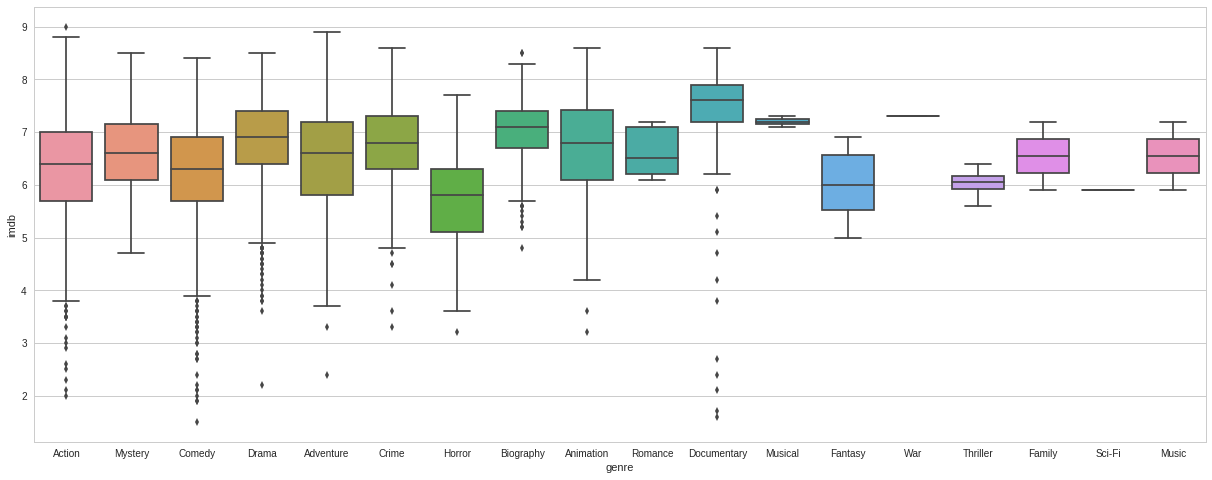

In [393]:
fig, ax = plt.subplots(figsize=(21,8))
ax = sns.boxplot(x = 'genre', y = 'imdb', data = movies)
plt.show()

**Inference 4: ** In the world of movies, there are a **lot** of outliers. I don't think a machine learning model could work well on datasets like this (to predict the likeability of a movie)- unless we have more attributes. 

In [394]:
# movie with lowest imdb rating
movies.iloc[movies['imdb'].idxmin()]

name       Saving Christmas
year                   2014
genre                Comedy
imdb                    1.5
meta                     18
gross                  2.78
runtime                  79
Name: 3991, dtype: object

In [395]:
# movie with highest imdb rating
movies.iloc[movies['imdb'].idxmax()]

name       The Dark Knight
year                  2008
genre               Action
imdb                     9
meta                    84
gross               534.86
runtime                152
Name: 2172, dtype: object

In [396]:
# movie with lowest meta rating
movies.iloc[movies['meta'].idxmin()]

name       Death of a Nation
year                    2018
genre            Documentary
imdb                     4.7
meta                       1
gross                   5.89
runtime                  108
Name: 4869, dtype: object

In [397]:
# movie with highest imdb rating
movies.iloc[movies['meta'].idxmax()]

name       Boyhood
year          2014
genre        Drama
imdb           7.9
meta           100
gross        25.38
runtime        165
Name: 3795, dtype: object

**Inference 5 - 8: ** 
  * IMDb:
    * Highest rated: The Dark Knight (2008). Score: 9
    * Lowest rated: Saving Christmas (2014). Score: 1.5
  * Metacritic:
      * Highest rated: Boyhood(2014). Score: 100
      * Highest rated: Death of a Nation(2018). Score: 1

# Gross

Each movie had anywhere from 1 to 3 genres. To simplify the process, I figured the first genre for each movie would be most accurate. Looking at the dataset, only the first 9 genres are the most abundant.

In [0]:
# sns.pairplot(movies, hue = 'genre')
# sns.lmplot(x = 'imdb', y = 'meta', data = movies, hue = 'genre')

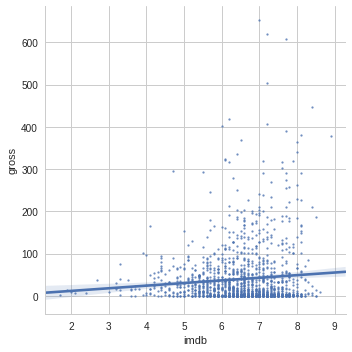

In [399]:
sns.lmplot(x = 'imdb', y = 'gross', data = movies.sample(1500), scatter_kws={"s": 5})

**Inference 9: ** No correlation between IMDb scores and movie box office. Same can be inferred for meta scores.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


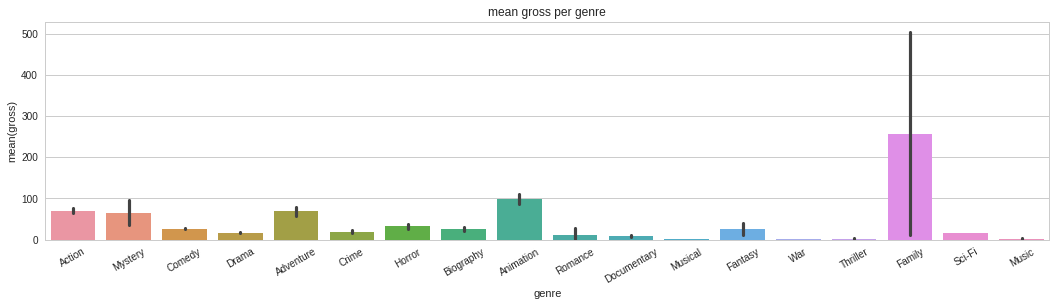

In [400]:
# be default, barplot shows mean. beow graph shows that family movies had the highest grossing per movie. 
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.barplot(x = 'genre', y = 'gross', data = movies)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('mean gross per genre')
plt.show()

Hmmm. Notice the black line for family movies. It tells us that there is a high change of it being erroneous.

In [401]:
movies['genre'].value_counts()

Comedy         1297
Drama          1042
Action          963
Crime           351
Biography       321
Animation       256
Adventure       242
Horror          180
Documentary     176
Mystery          15
Fantasy          14
Romance           8
Thriller          6
Musical           2
Music             2
Family            2
Sci-Fi            1
War               1
Name: genre, dtype: int64

In [402]:
movies[movies['genre'] == 'Family']

,name,year,genre,imdb,meta,gross,runtime
1201,Raise Your Voice,2004,Family,5.9,33,10.41,103
4502,Beauty and the Beast,2017,Family,7.2,65,504.01,129


In [425]:
temp = movies.groupby('genre').sum()
temp['ppm'] = temp['gross'] / temp['runtime']
temp.sort_values('ppm', ascending =False).head()

,imdb,meta,gross,runtime,ppm
genre,,,,,
Family,13.1,98,514.42,232,2.217328
Animation,1720.9,15449,24947.05,23922,1.042850
Action,6059.0,47857,67390.53,108138,0.623190
Adventure,1570.0,13489,16524.08,26933,0.613525
Mystery,98.8,832,949.80,1638,0.579853


**Inference 12: ** Family movies had the best profit per movie value. (514.42 million for 2 movies!) and earned a whopping 2.2 million dollars for 1 minute of screentime. This amount was largely due to Beauty and the Beast.

**Inference 13:** The most profitable movie genres are Family, Animation, and Action.



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


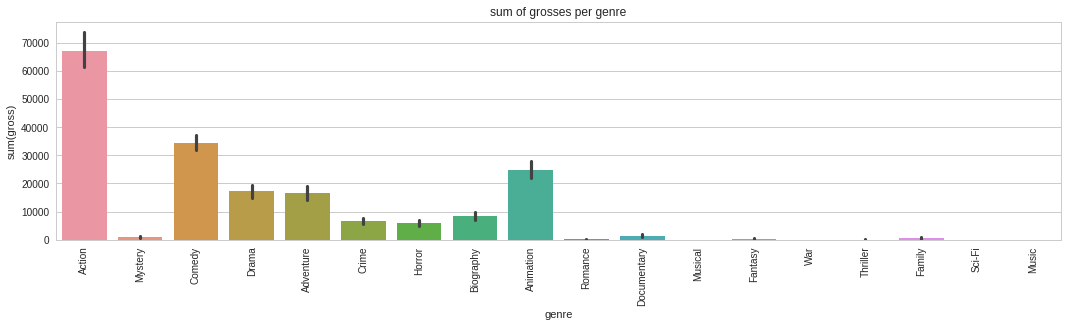

In [403]:
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.barplot(x = 'genre', y = 'gross', data = movies, estimator = sum)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('sum of grosses per genre')
plt.show()

**Inference 14: ** Action movies had the most profits (67k million), followed by comedy movies (34k million) and then animation movies (25k million).

# Genre

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


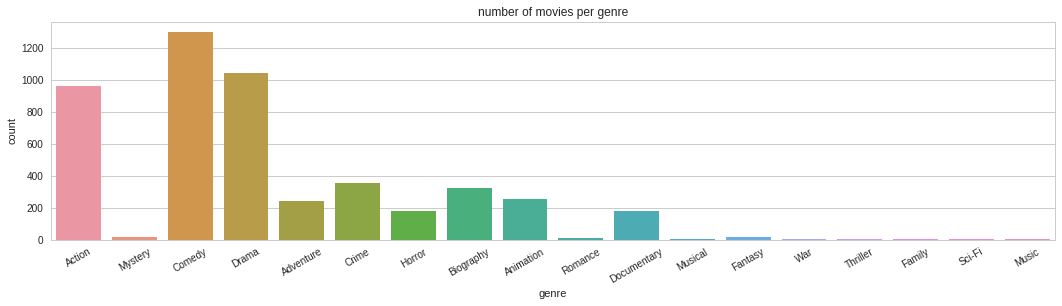

In [404]:
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.countplot(x = 'genre', data = movies)
ax.set_xticklabels(ax.get_xticklabels() ,rotation = 30)
plt.title('number of movies per genre')
plt.show()

**Inference 14:**: Comedy movies were the most frequently released, followed by drama and action movies.



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


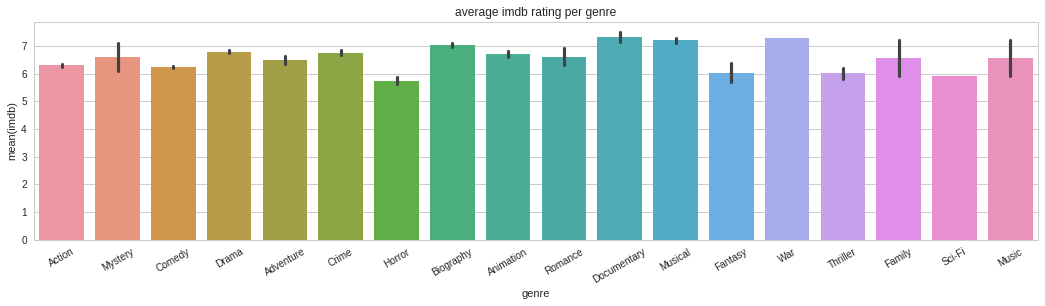

In [405]:
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.barplot(x = 'genre', y = 'imdb', data = movies)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('average imdb rating per genre')
plt.show()

**Inference 15:**For IMDb ratings, on average, horror movies got the lowest ratings while war, documentary, and musical movies seem to get the highest. 

**Inference 16:** IMDb movies tend to approximately get the same ratings regardless of genre.




/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


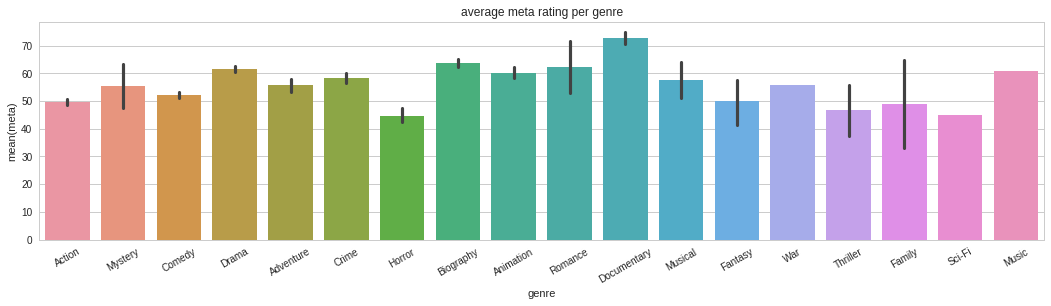

In [406]:
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.barplot(x = 'genre', y = 'meta', data = movies)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('average meta rating per genre')
plt.show()

**Inference 17:**: For meta ratings, documentary movies get the highest average rating.

**Inference 18:**: Mean ratings for each genre for metacritic tend to vary for each genre, unlike IMDb ratings.

**Inference 19:** Horror movies are the most disliked. 

**Inference 20:** Documentary movies are the most liked.

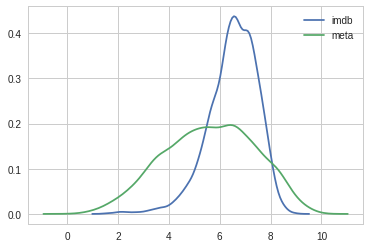

In [407]:
fig, ax = plt.subplots()
sns.kdeplot(movies['imdb'], ax=ax)
sns.kdeplot(movies['meta']/10, ax=ax)

# Runtime

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


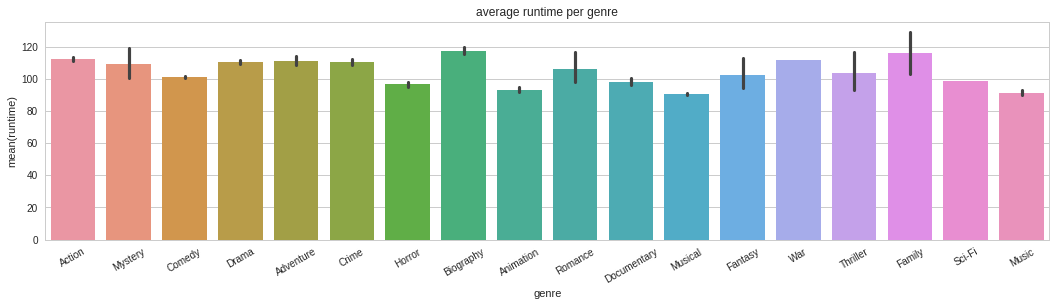

In [408]:
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.barplot(x = 'genre', y = 'runtime', data = movies)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('average runtime per genre')
plt.show()

In [409]:
movies.groupby(['genre']).mean().sort_values('runtime').iloc[0]

imdb        7.20
meta       57.50
gross       0.08
runtime    90.50
Name: Musical, dtype: float64

In [410]:
movies.groupby(['genre']).mean().sort_values('runtime').iloc[-1]

imdb         7.036449
meta        63.781931
gross       25.985452
runtime    117.529595
Name: Biography, dtype: float64

**Inference 21:** Biography movies had the longest average duration. (117 mins). Musical movies had the lowest. (90 minutes)

In [411]:
movies.loc[movies['runtime'].idxmin()]

name       Ghosts of the Abyss
year                      2003
genre              Documentary
imdb                       6.9
meta                        67
gross                    17.09
runtime                     61
Name: 1020, dtype: object

In [412]:
movies.loc[movies['runtime'].idxmax()]

name       The Best of Youth
year                    2003
genre                  Drama
imdb                     8.5
meta                      89
gross                   0.25
runtime                  366
Name: 946, dtype: object

**Inference 22:** Longest movie was 'The Best of Youth', which ran for 366 minutes (6 hours). Shortest movie was 'Ghost of the Abyss', which ran for 61 minutes. (1 hour)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


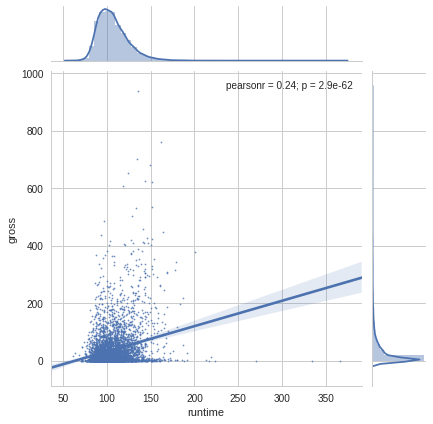

In [413]:
sns.jointplot(x = 'runtime', y = 'gross', data = movies,  kind = 'reg', scatter_kws={"s": 3})
plt.show()

**Inference 23:** Runtime and box office are slightly correlated. Meaning, if the duration of a movie is more, it earns more. (with a probability of 0.3)

